In [ ]:
using Pkg
Pkg.activate("NB07")

In [35]:
using Ripserer, TSne
using Plots, LinearAlgebra, StatsBase, DelimitedFiles
import Base.Iterators: product
gr(); #change to plotlyjs() for interactive 3D plots

# Topological Data Analysis

We use the software package [Ripserer.jl](https://github.com/mtsch/Ripserer.jl) to compute the persistent homology of two example data sets.

## Persistent homology of an ellipse

The first example is $n=50$ point on the ellipse $x^2/a+y^2/b = 1$ with $a=2,b=1$.

We generate a random data set `P`.

In [30]:
a, b = 2, 1
n = 50
P = [[a * cos(ϕ); b * sin(ϕ)] + 0.1 .* randn(2) for ϕ in rand(0:0.01:2π, n)];

Let us first visualize the data.

In [31]:
data = Tuple.(P)
scp = scatter(data,  size = (800,300),
        markercolor = :steelblue, markersize = 5,
        aspect_ratio = :equal, label = false)

The command to compute persistent homology for the <i>Vietoris-Rips</i> complex is `ripserer`:

In [32]:
ph =  ripserer(data) # Ripserer.jl takes as input a Vector of Tuples

2-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 50-element 0-dimensional PersistenceDiagram
 1-element 1-dimensional PersistenceDiagram

The information in `ph` is summarized in a barcodep lot:

In [33]:
barcode(ph, size = (800,300))

or a persistence plot:

In [34]:
plot(ph, size = (600,400))

Let us now consider the homology of the Vietoris-Rips complex $\mathrm{VR}_{r}(P)$ at level $r=1/4$.

In [35]:
r = 0.25

0.25

The first Betti number of $\mathrm{VR}_{1/4}(P)$ can be extracted from `ph` by counting the number of bars that  start earlier than $2r$ and end after $2r$.

In [36]:
β₁ = count(b -> b[1] <= 2r < b[2], ph[2])

0

To visualize $\mathrm{VR}_{1/4}(P)$ we compute all pairs of points that are at most $2r$ apart:

In [37]:
pairwise_dists = map(p -> norm(p[1] - p[2]), product(P,P));
edges = findall(0 .< pairwise_dists .< 2r);
edges[1:5]

5-element Vector{CartesianIndex{2}}:
 CartesianIndex(2, 1)
 CartesianIndex(4, 1)
 CartesianIndex(5, 1)
 CartesianIndex(18, 1)
 CartesianIndex(22, 1)

In [38]:
length(edges)

260

and all triples of points that are pairwise at most $2r$ apart:

In [39]:
triple_dists =  map(p -> maximum([norm(p[i] - p[j]) for i in 1:2 for j in i:3]), product(P,P,P)); 
triangles = findall(0 .< triple_dists .< 2r);
length(triangles)

1890

We plot the triangles and edges:

In [40]:
Triangle(a,b,c) = Shape([a[1], b[1], c[1]], [a[2], b[2], c[2]])

Triangle (generic function with 1 method)

In [46]:
plot(xlims = (-a-0.25, a+0.25), ylims = (-a-0.25, a+0.25))
for t in triangles
   vertices = [[P[t[i]][j] for j in 1:2] for i in 1:3]
   plot!(Triangle(vertices[1], vertices[2], vertices[3]), 
        fillcolor = :wheat, opacity = 0.2, label = false)
end
for e in edges
   vertices = [P[e[1]],  P[e[2]]]
   plot!(first.(vertices), last.(vertices), label = false,
            linecolor = :grey, linewidth = 1, linealpha = 0.5)
end
scatter!(data, markercolor = :steelblue, markersize = 4, label = "β₁ = $(β₁), r = $(r)")

We can also plot triangles and edges for varying $r$:

In [42]:
A = @animate for r in 0:0.1:1
    β₁ = count(b -> b[1] <= 2r < b[2], ph[2])
    edges = findall(0 .< pairwise_dists .<= 2r)
    plot(xlims = (-a-0.5, a+0.5), ylims = (-a-0.5, a+0.5))
    for e in edges
       vertices = [P[e[1]],  P[e[2]]]
       plot!(first.(vertices), last.(vertices), label = false,
                linecolor = :grey, linewidth = 1, linealpha = 0.5)
    end
    scatter!(data, markercolor = :steelblue, markersize = 4, label = "β₁ = $(β₁), r = $(r)")
end

Animation("/var/folders/dm/81rrvn3d6hxb31lf0brq019m0000gn/T/jl_MUsTNf", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png"])

┌ Info: Saved animation to 
│   fn = /Users/pb/Documents/Lehre/Uni Osnabrück/Math Methoden der Datenanalyse 2022/MathData-SoSe22/Notebooks/tmp.gif
└ @ Plots /Users/pb/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/pb/Documents/Lehre/Uni Osnabrück/Math Methoden der Datenanalyse 2022/MathData-SoSe22/Notebooks/tmp.gif")
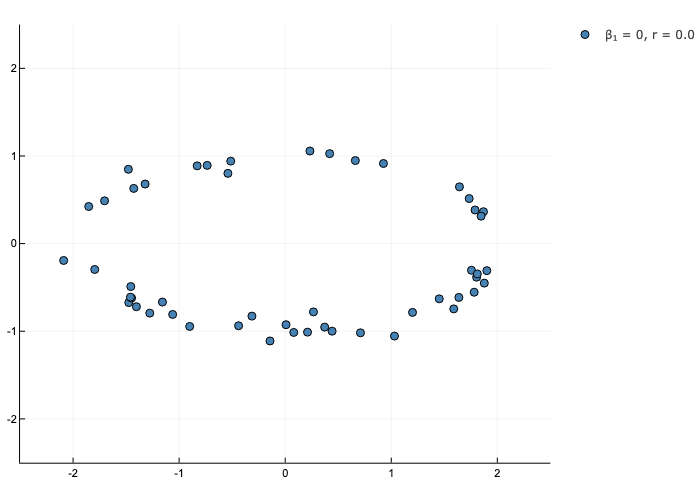

In [43]:
gif(A, fps = 2)

We can also get the information which edges form the 1-dimensional boundary of the hole.

For this we use `ripserer` with option `alg = :involuted`.

In [44]:
diagram_cycles = ripserer(data, alg = :involuted)
boundary = diagram_cycles[2][end]

[0.764, 1.78) with:
 birth_simplex: Simplex{1, Float64, Int64}
 death_simplex: Simplex{2, Float64, Int64}
 representative: 24-element Chain{Mod{2},Simplex{1, Float64, Int64}}

In [45]:
plot(boundary, data, linewidth = 3, linecolor = :indianred, legend = false, size = (800,300))
scatter!(data, markercolor = :steelblue, markersize = 4)
scatter!(boundary, data, markercolor = :indianred, markersize = 4)

# The state space of the cyclooctane molecule

The second example considers [data points](https://www.juliahomotopycontinuation.org/examples/cyclooctane/) from the state space of [cyclooctane](https://en.wikipedia.org/wiki/Cyclooctane).

In [3]:
M = readdlm("cyclooctane.txt", '\t', Float64, '\n');

In [4]:
n = size(M, 2)

4058

[Cyclooctane](https://en.wikipedia.org/wiki/Cyclooctane) (CH₂)₈ is a molecule that consists of 8 carbon atoms aligned in a ring, and 8 hydrogen atoms attached to the carbon atoms. 

The distance $c>0$ between neighboring carbon atoms is fixed. The data has $c=1$.

The energy of a configuration $z=(z_1,\ldots,z_8)$ is minimized when the angles between successive bonds are all equal to $\alpha\approx 115^\circ$. 

Therefore, the positions $z_i\in\mathbb{R}^3$ of the carbon atoms satisfy the algebraic equations

$$\Vert z_1-z_2\Vert^2 = \cdots =  \Vert z_7-z_8\Vert^2=\Vert z_8-z_1\Vert^2 = c^2,$$

and

$$\Vert z_1-z_3\Vert^2 = \cdots =  \Vert z_6-z_8\Vert^2=\Vert z_7-z_1\Vert^2 =\Vert z_8-z_2\Vert^2 = c^2(1-\cos(\alpha)).$$

The data in `M` is normalized: The equations for the positions are invariant under simultaneous translation and rotation of the $z_i$. The data is such that $z_1$ is chosen to be the origin, $z_8=(c,0,0)$ and $z_7$ is rotated, such that its last entry is equal to zero. 

Thus, every data point in $M$ is a vector in $\mathbb R^{17}$, such that the positions of the 8 carbon atoms are the columns of the following matrix:

In [5]:
s = M[:,rand(1:n)]
c = [zeros(3) s[1:3] s[4:6] s[7:9] s[10:12] s[13:15] [s[16]; s[17]; 0] [1; 0; 0]]

3×8 Matrix{Float64}:
 0.0  -0.422618  -0.36434   0.42067  0.859533  0.820713  1.42262   1.0
 0.0   0.773399   0.742097  1.22119  1.8827    1.65329   0.906308  0.0
 0.0   0.472491   1.4703    1.86303  1.25492   0.282365  0.0       0.0

We visualize $c$ as follows:

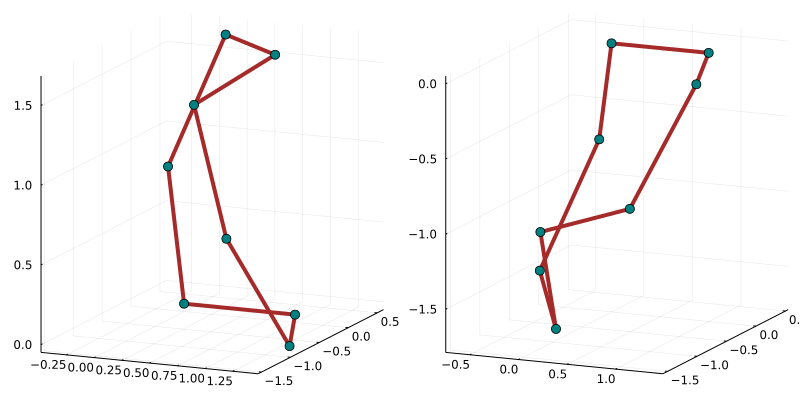

In [39]:
plot(legend = false, layout = (1,2), size = (800,400))
s = M[:,rand(1:n)]
    c = [zeros(3) s[1:3] s[4:6] s[7:9] s[10:12] s[13:15] [s[16]; s[17]; 0] [1; 0; 0]]
    for (i, j) in zip(1:8, [8;1:7]) 
        plot!(c[1, [i;j]], c[2, [i;j]], c[3, [i;j]], lw = 4, color = :brown, subplot = 1)
    end; scatter!(c[1,:], c[2,:], c[3,:], color = :teal, markersize = 5, subplot = 1)

s = M[:,rand(1:n)]
    c = [zeros(3) s[1:3] s[4:6] s[7:9] s[10:12] s[13:15] [s[16]; s[17]; 0] [1; 0; 0]]
    for (i, j) in zip(1:8, [8;1:7]) 
        plot!(c[1, [i;j]], c[2, [i;j]], c[3, [i;j]], lw = 4, color = :brown, subplot = 2)
    end; scatter!(c[1,:], c[2,:], c[3,:], color = :teal, markersize = 5, subplot = 2)

Let us now analyse the data in `M`.

In [7]:
cyclooctane = [Tuple(M[:,i]) for i in 1:size(M,2)];

There are now $n=4058$ data points in `cyclooctane`. 

In [8]:
length(cyclooctane)

4058

Let us first compute the number of connected components of the data.

For this we set the option `dim_max = 0` (the default is `dim_max = 1`).

We also set the option `reps = true`.

In [9]:
components = ripserer(cyclooctane, reps=true, dim_max = 0);
plot(components)

We see two connected components. 

They correspond to the two connected components of $O(3)$ and encode orientation. 

We consider only one of the two components in the following.

In [10]:
i = index.(representative(components[1][end-1])); # here we need reps = true
cyclooctane₁ = cyclooctane[i];
M₁ = M[:,i]
size(M₁)

(17, 1966)

Let us visualize the component `M₁` using a random orthogonal projection.

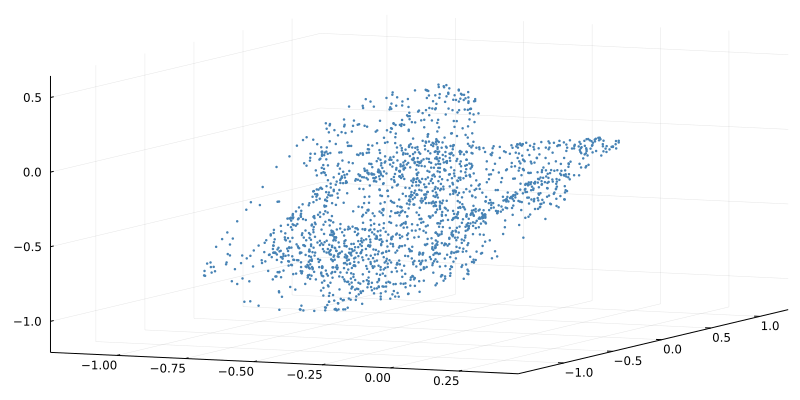

In [43]:
Q = qr(randn(17,17)).Q[1:3,:]
NN = (Q * M₁)'
scatter(NN[:,1], NN[:,2], NN[:,3], size = (800,400),
        markercolor = :steelblue, markerstrokecolor = :steelblue, markersize = 1.5, label = false)

We also visualize the component `M₁` using [t-Stochastic Neighbor Embedding](https://github.com/lejon/TSne.jl).

In [ ]:
N = tsne(M₁', 2, 0, 75, 12.0);

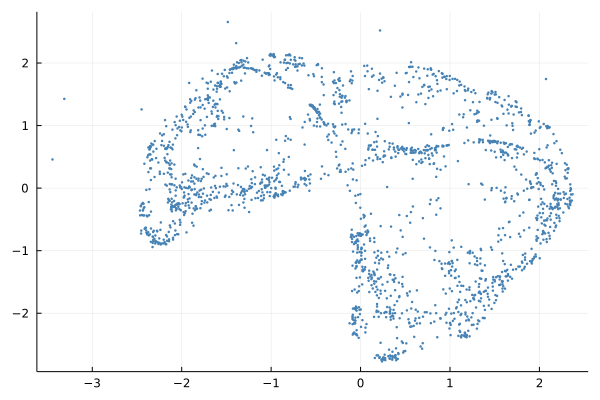

In [45]:
scatter(N[:,1], N[:,2], 
        markercolor = :steelblue, markerstrokecolor = :steelblue, markersize = 1.5, label = false)

We compute persistent homology for $500$ data points from our component.

In [ ]:
w = 1:700
ph_cycloctane = ripserer(cyclooctane₁[w], dim_max = 2);

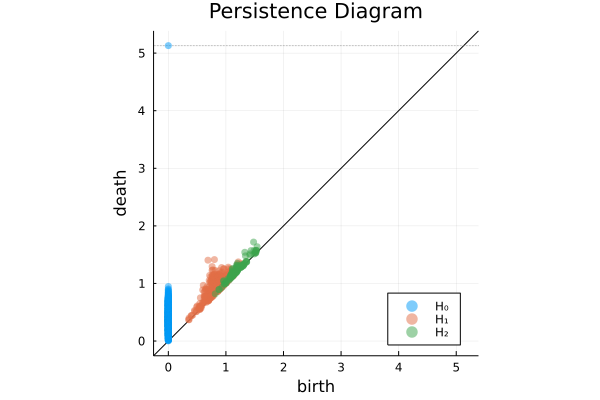

In [46]:
plot(ph_cycloctane)

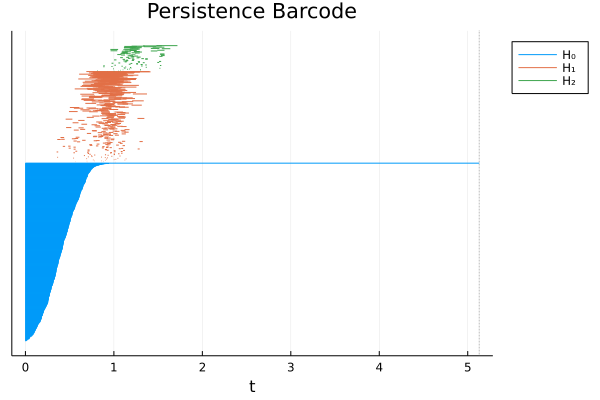

In [47]:
barcode(ph_cycloctane)

We see one connected components and indications for $\beta_1=2$ and $\beta_2=1$. 
    
The paper [Topology of cyclo-octane energy landscape](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3188624/) reports  $\beta_1=1$ and $\beta_2=2$.